In [1]:
import tensorflow as tf
import numpy as np
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
from get_network import get_model, normalize
from regularized_explanations import ops, ig
from tqdm import tqdm
from scipy import special
import scipy.misc
import os
import json
import shap

Using TensorFlow backend.


In [2]:
model, sess = get_model()

In [19]:
images = np.load('data/images.npy')
baseline = np.zeros(images.shape)
labels = np.load('data/labels.npy')

In [20]:
softmax_logits_op = tf.nn.softmax(model.logits)

In [8]:
alpha_values = np.linspace(0.0, 1.0, num=51)

In [26]:
selected_logits_array = np.zeros((4, alpha_values.shape[0]))

In [27]:
i = 0
for alpha in alpha_values:
    interpolated_images = baseline * (1.0 - alpha) + images * alpha
    softmax_logits = sess.run(softmax_logits_op, feed_dict={model.images_pl: interpolated_images})
    class_selected_logits = softmax_logits[np.arange(4), labels]
    selected_logits_array[:, i] = class_selected_logits
    i += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


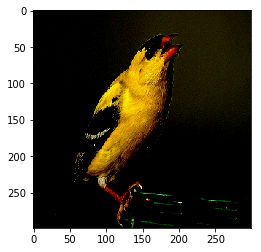

In [33]:
plt.imshow(images[2])

In [35]:
data = pd.DataFrame({
    'alpha': alpha_values,
    'house_finch': selected_logits_array[0, :],
    'rubber_eraser': selected_logits_array[1, :],
    'goldfinch': selected_logits_array[2, :],
    'killer_whale': selected_logits_array[3, :]
})

In [41]:
melted_data = pd.melt(data, id_vars=['alpha'], var_name='image', value_name='softmax_output')

In [58]:
interp_images = baseline * (1.0 - 0.04) + images * alpha
interp_images = interp_images * 0.5 + 0.5

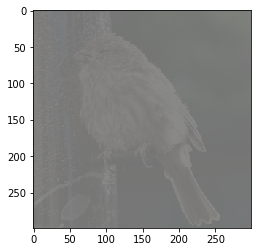

In [64]:
interp_images = baseline * (1.0 - 0.08) + images * 0.08
interp_images = interp_images * 0.5 + 0.5
plt.imshow(interp_images[0])

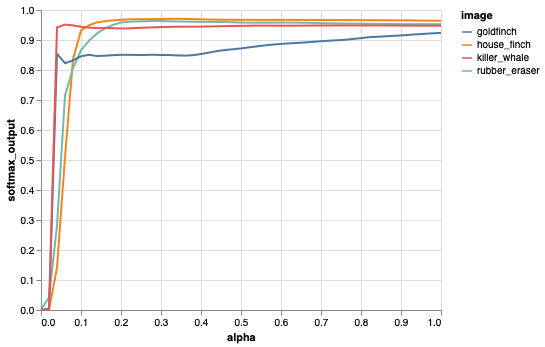

In [47]:
alt.Chart(melted_data).mark_line().encode(
    x=alt.X('alpha:Q'),
    y=alt.Y('softmax_output:Q'),
    color=alt.Color('image:N')
)

In [44]:
melted_data.head()

,alpha,image,softmax_output
0,0.00,house_finch,0.000140
1,0.02,house_finch,0.001282
2,0.04,house_finch,0.140955
3,0.06,house_finch,0.509088
4,0.08,house_finch,0.835879


In [65]:
data.to_csv('data/output_alpha.csv', index=False)